In [132]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage
import time
from sklearn.metrics import mean_absolute_error

In [ ]:
img = cv2.imread('../W_0LvEY_Zus.jpg')/255.0
max_size = 1000
H, W = img.shape[0], img.shape[1]
if H > W:
    if H > max_size:
        img = cv2.resize(img, (int(W * max_size / H)), max_size)
else:
    if W > max_size:
        img = cv2.resize(img, (max_size, int(H * max_size / W)))
        
H, W = img.shape[0], img.shape[1]
padding = int(W * 0.1 if H > W else H * 0.1)
zeros = np.zeros((H + padding * 2, W + padding * 2, 3))
zeros[padding: padding + H, padding: padding + W] = img
img = zeros
mask_img = np.zeros(img.shape)

blurs = dict()
for i in range(1, 100):
    blurs[i] = cv2.blur(img, (i, i))

In [ ]:
plt.imshow(img[:,:,::-1])

In [129]:
class Stroke():
    def __init__(self, image, dispersion, amount, speed, ttl):
        image_size = image.shape[:2]
        self.dispersion = dispersion
        x = np.random.randint(0, image_size[1], 1)
        y = np.random.randint(0, image_size[0], 1)
        self.center = np.concatenate([x, y], axis=0).astype(np.float)
        
        self.particles_angle = np.random.uniform(0, 2 * np.pi, amount)
        self.particles_radius = np.fabs(np.random.normal(0, dispersion*2, amount))
        
        self.angle = np.random.uniform(0, 2 * np.pi)
        self.rotation = np.random.uniform(-np.pi/60, np.pi/60)
        self.color = image[y[0], x[0]]
        self.speed = np.random.normal(speed, speed/3, 1)
        self.status = 'running'
        self.ttl = np.random.normal(ttl)
        self.ttl = 0.5 if self.ttl < 0.5 else self.ttl
        
        
    def get_mean_color(self, image, x, y):
        if 0 < x < image.shape[1] and 0 < y < image.shape[0]:
            return blurs[self.dispersion][int(y), int(x)]
        else:
            return self.color
        
        
    def update(self, image):  
        # add removal of some points
        self.last_center = self.center.copy()
        self.angle += self.rotation
        
        self.center[0] += np.cos(self.angle) * self.speed
        self.center[1] += np.sin(self.angle) * self.speed
        
        self.particles_angle += self.rotation
        mean_color = self.get_mean_color(image, self.center[0], self.center[1])
        self.color = self.color - (self.color - mean_color)/2
        self.ttl -= np.random.uniform(0, 0.05)
        if self.ttl <= 0:
            self.status = 'deleted'
        
        
    def draw(self, image):
        offset_x = np.cos(self.particles_angle) * self.particles_radius
        offset_y = np.sin(self.particles_angle) * self.particles_radius
        positions = (self.center.reshape(2, 1) + [offset_x, offset_y]).T.reshape(-1, 1, 2)
        last_positions = (self.last_center.reshape(2, 1) + [offset_x, offset_y]).T.reshape(-1, 1, 2)
        points = np.concatenate([last_positions, positions], axis=1).astype(np.int32)
        cv2.polylines(image, points, False, self.color, 2)   


In [130]:
max_strokes = 10
min_dispersion = 5
max_dispersion = 18
min_amount = 50
max_amount = 100
max_image_size = max(img.shape[:2])
base_speed = max_image_size/100
base_ttl = 5
strokes = [Stroke(img, 
                  dispersion=np.random.randint(min_dispersion, max_dispersion), 
                  amount=np.random.randint(min_amount, max_amount),
                  speed=base_speed,
                  ttl=base_ttl) for _ in range(max_strokes)]
total_img_value = img.sum()
error = 1
iterations = 0

while error > 0.1 and iterations < 5000:
    strokes = [st for st in strokes if st.status != 'deleted']
    for _ in range(max_strokes - len(strokes)):
        strokes.append(Stroke(img, 
                              np.random.randint(int(min_dispersion), int(max_dispersion)), 
                              np.random.randint(int(min_amount), int(max_amount)),
                              speed=base_speed,
                              ttl=base_ttl))
        
    for st in strokes:
        st.update(img)
        st.draw(mask_img)
        
    if iterations % 200 == 0:
        error = np.abs((img - mask_img)).sum() / total_img_value
        min_dispersion = 8 - (7 * (1 - error))
        max_dispersion = 18 - (16 * (1 - error))
        min_amount = 50 - (49 * min((1.1 - error), 1))
        max_amount = 100 - (95 * min((1.1 - error), 1))
        base_speed = max_image_size/100 - (max_image_size/100 * 0.9 * (1 - error))
        max_strokes = int(10 + 190 * ((1 - error) ** 8))
        base_ttl = 5 - (4 * (1 - error))
        print(iterations, error)
        
    cv2.imshow('BlindArtist', mask_img)
    key = cv2.waitKey(1)
    if key == 27:      # esc
        break
    
    iterations += 1
        
 

0 0.9763816498483923
200 0.5075456301391551
400 0.42859218508297425
600 0.3460562580320358
800 0.29399781745051917
1000 0.24997083387666885
1200 0.21818742562377821
1400 0.19392313063100536
1600 0.1810613487344895
1800 0.1699842962539482
2000 0.16171783343621754
2200 0.15472801855887183
2400 0.1504699408381626
2600 0.14886767652842367
2800 0.14514661941101523
3000 0.14535492488267668
3200 0.14286694774022515
3400 0.14272189441861355
3600 0.1421497070975141
3800 0.14063953994462877
4000 0.13837772854110814
4200 0.1385527569555422
4400 0.13908751933981428
4600 0.1364210262231543
4800 0.13558536133215873


In [131]:
cv2.destroyAllWindows()

In [75]:
a = np.arange(0, 1, 0.01)

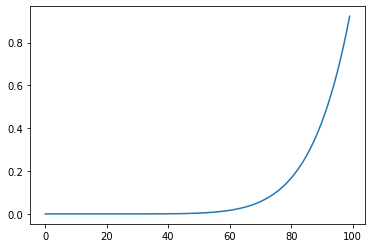

In [82]:
plt.plot(np.arange(0, 100), a**8)